## Introdução

Este notebook é apenas um exemplo do poder do pacote geopandas em criar visualizações de dados impactantes e como podemos usar essas ferramentas para extrair insights valiosos. Utilizando dados disponibilizados pela Secretaria de Segurança Pública e Defesa Social (SSPDS) do estado do Ceará, explorei a utilidade dessas ferramentas. Fortaleza, a capital do Ceará, com uma população de 2,4 milhões de pessoas de acordo com o último censo (2022), é conhecida por sua deslumbrante orla. No entanto, nos últimos anos, ganhou notoriedade como uma das cidades mais perigosas do mundo. Por esse motivo, examinei os dados de segurança fornecidos pela SSPDS, juntamente com os dados geoespaciais disponibilizados pela Prefeitura de Fortaleza. É importante ressaltar que o objetivo deste notebook não foi realizar uma análise exploratória detalhada, mas sim demonstrar como podemos aproveitar a visualização de dados, especialmente utilizando o pacote geopandas, para trabalhar com dados geoespaciais e comunicar informações de forma eficaz.

## 1. Libs, Funções e Obtenção dos Dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import MultiPolygon, Polygon

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

In [2]:
def plot_bar(df, eixo_x, eixo_y, titulo, var = None, legenda = None, ano_destaque = None):
    "Plot de um fráfico de barras."
    plt.figure(figsize=(15, 8))

    if ano_destaque != None:
        cor = ['#f6b48e'] * len(df)
        for ano in ano_destaque:
            cor[df_ocor_ano[df_ocor_ano['ANO'] == ano].index[0]] = '#281e5d'
    else:
        cor = sns.color_palette("rocket")
        
    ax = sns.barplot(data = df, x = eixo_x, y = eixo_y, hue = legenda, palette = cor)
    
    plt.xlabel(eixo_x)
    plt.ylabel(eixo_y)
    plt.title(titulo)

    if var != None:
        for i, row in df.iterrows():
            if not pd.isna(row[var]):
                qtde_formatted = '{:,.0f}'.format(row[eixo_y]) 
                plt.text(row.name, row[eixo_y], f'{qtde_formatted}\n{row[var]:.2f}%', ha='center', va='bottom')
    
    plt.ylim(0, df[eixo_y].max() * 1.10)
    
    plt.show()

In [3]:
def ais_bairro(bairro):
    "Classifica os dados geoespaciais em AIS"
    if bairro in ['CAIS DO PORTO', 'VICENTE PINZON', 'MUCURIPE', 'ALDEOTA', 'PRAIA DE IRACEMA', 'MEIRELES', 'VARJOTA']:
        return 'AIS 01' 
    elif bairro in ['CONJUNTO CEARÁ I', 'CONJUNTO CEARÁ II', 'GENIBAÚ', 'BOM JARDIM', 'GRANJA PORTUGAL', 'GRANJA LISBOA', 'SIQUEIRA']:
        return 'AIS 02'
    elif bairro in ['MESSEJANA', 'ANCURI', 'PEDRAS', 'BARROSO', 'JANGURUSSU', 'CONJUNTO PALMEIRAS', 'CURIÓ', 'LAGOA REDONDA', 'GUAJERU', 'SÃO BENTO', 'PAUPINA', 'PARQUE SANTA MARIA', 'COAÇU']:
        return 'AIS 03'
    elif bairro in ['CENTRO', 'MOURA BRASIL', 'CARLITO PAMPLONA', 'ÁLVARO WEYNE', 'ELLERY', 'MONTE CASTELO', 'FARIAS BRITO', 'SÃO GERARDO', 'JACARECANGA']:
        return 'AIS 04'
    elif bairro in ['PARANGABA', 'VILA PERI', 'ITAOCA', 'ITAPERI', 'RACHEL DE QUEIROZ', 'PANAMERICANO', 'JARDIM AMÉRICA', 'BENFICA', 'DEMÓCRITO ROCHA', 'COUTO FERNANDES', 'MONTESE', 'DAMAS', 'BOM FUTURO', 'VILA UNIÃO', 'JOSÉ BONIFÁCIO', 'PARREÃO', 'FÁTIMA', 'SERRINHA', 'AEROPORTO']:
        return 'AIS 05'
    elif bairro in ['ANTÔNIO BEZERRA', 'QUINTINO CUNHA', 'OLAVO OLIVEIRA', 'PADRE ANDRADE', 'BELA VISTA', 'PRESIDENTE KENNEDY', 'PARQUELÂNDIA', 'AMADEU FURTADO', 'PARQUE ARAXÁ', 'RODOLFO TEÓFILO', 'BONSUCESSO', 'JOÃO XXIII', 'JÓQUEI CLUBE', 'HENRIQUE JORGE', 'AUTRAN NUNES', 'PICI', 'DOM LUSTOSA']:
        return 'AIS 06'
    elif bairro in ['EDSON QUEIROZ', 'JARDIM DAS OLIVEIRAS', 'SABIAGUABA', 'CAMBEBA', 'JOSÉ DE ALENCAR', 'PARQUE IRACEMA', 'PARQUE MANIBURA', 'SAPIRANGA / COITÉ', 'CIDADE DOS FUNCIONÁRIOS', 'CAJAZEIRAS', 'ALTO DA BALANÇA', 'AEROLÂNDIA', 'BOA VISTA / CASTELÃO', 'DIAS MACÊDO', 'PARQUE DOIS IRMÃOS', 'PASSARÉ']:
        return 'AIS 07'
    elif bairro in ['BARRA DO CEARÁ', 'VILA VELHA', 'JARDIM GUANABARA', 'CRISTO REDENTOR', 'PIRAMBÚ', 'FLORESTA', 'JARDIM IRACEMA']:
        return 'AIS 08'
    elif bairro in ['CONJUNTO ESPERANÇA', 'NOVO MONDUBIM', 'CANINDEZINHO', 'MANOEL SÁTIRO', 'PARQUE PRESIDENTE VARGAS', 'PARQUE SÃO JOSÉ', 'MARAPONGA', 'JARDIM CEARENSE', 'PARQUE SANTA ROSA', 'MONDUBIM', 'ARACAPÉ', 'PLANALTO AYRTON SENNA', 'PREFEITO JOSÉ WALTER']:
        return 'AIS 09'
    elif bairro in ['PAPICU', 'DE LOURDES', 'CIDADE 2000', 'PRAIA DO FUTURO I', 'PRAIA DO FUTURO II', 'MANUEL DIAS BRANCO', 'GUARARAPES', 'ENGENHEIRO LUCIANO CAVALCANTE', 'SÃO JOÃO DO TAUAPE', 'SALINAS', 'JOAQUIM TÁVORA', 'DIONÍSIO TORRES', 'COCÓ']:
        return 'AIS 10'

### 1.1 Obtendo os Dados

In [4]:
planilhas = ['FURTOS', 'CVP', 'CVLI', 'CRIMES_SEXUAIS', 'ARMA_FOGO', 'APREENSAO_ENTORPECENTES']

dfs = {}

df_desc = pd.read_excel('C:\\Users\\done_\\OneDrive\\Área de Trabalho\\Dados_SSPDS.xlsx', sheet_name = 'DESC')

# lendo os dados geoespaciais
df_bairros = pd.read_csv('C:\\Users\\done_\\OneDrive\\Área de Trabalho\\bairros.csv', sep = ',')

# lendo os dados de segurança publica
for planilha in planilhas:
    dfs[planilha] = pd.read_excel('C:\\Users\\done_\\OneDrive\\Área de Trabalho\\Dados_SSPDS.xlsx', sheet_name = planilha)

    dfs[planilha]['ORIGEM'] = planilha

    dfs[planilha]['QTDE'] = 1

    dfs[planilha]['ANO'] = dfs[planilha]['Data'].dt.year

    dfs[planilha] = dfs[planilha].merge(right = df_desc, on = 'AIS', how = 'left')

# montando um df com todas as ocorrências
df_ocor = pd.concat([dfs[planilha] for planilha in planilhas], ignore_index=True)

df_ocor.drop(columns = ['Natureza', 'Meio Empregado', 'Gênero', 'Idade da Vítima', 'Escolaridade da Vítima', 'Raça da Vítima', 'Quantidade', 'Quantidade (Kg)', 'Tipo de Entorpecente'], inplace = True)



In [5]:
# columetria e tipo de dado
df_ocor.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844473 entries, 0 to 1844472
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   AIS               1844473 non-null  object        
 1   Município         1844473 non-null  object        
 2   Dia da Semana     1844473 non-null  object        
 3   Data              1844473 non-null  datetime64[ns]
 4   Hora              1844473 non-null  object        
 5   ORIGEM            1844473 non-null  object        
 6   QTDE              1844473 non-null  int64         
 7   ANO               1844473 non-null  int32         
 8   Bairro/Município  1753608 non-null  object        
 9   Território        1753608 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(7)
memory usage: 133.7+ MB


## 2. Análise Exploratória

### 2.1 Ocorrências por Ano

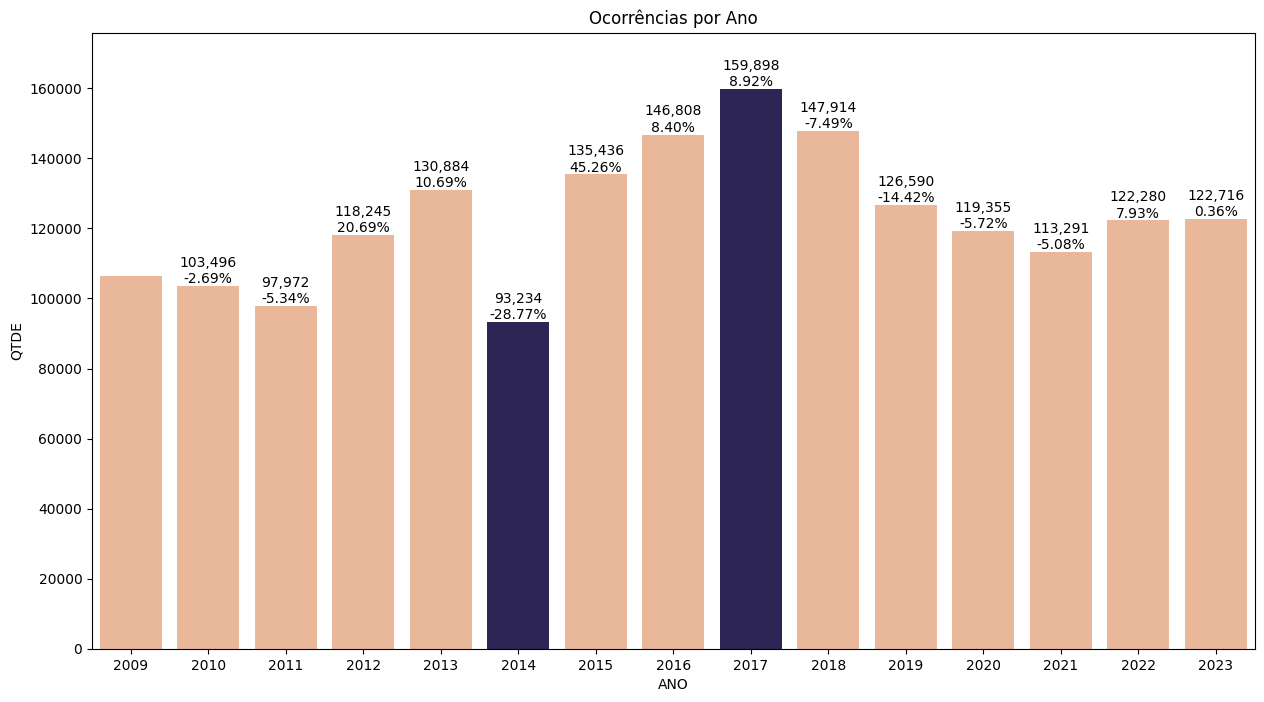

In [6]:
df_ocor_ano = df_ocor[['ANO', 'QTDE']].groupby(by = ['ANO'], as_index = False).sum()

df_ocor_ano.sort_values(by = 'ANO')

df_ocor_ano['VAR'] = df_ocor_ano['QTDE'].pct_change() * 100

plot_bar(df_ocor_ano, 'ANO', 'QTDE', 'Ocorrências por Ano', var = 'VAR', ano_destaque = [2014, 2017])

No gráfico que representa a quantidade de ocorrências por ano, observamos que 2017 se destaca como o ano com o maior número de ocorrências, atingindo quase 160 mil registros. Por outro lado, o ano de 2014 foi o que registrou o menor número de ocorrências, o que é notável, considerando que coincidiu com a realização da Copa do Mundo, na qual o Brasil foi o país-sede e Fortaleza foi um dos locais dos jogos. Desde 2018, observamos uma tendência de redução no número de ocorrências. No entanto, é interessante notar que entre 2022 e 2023 houve um aumento em relação aos quatro anos anteriores

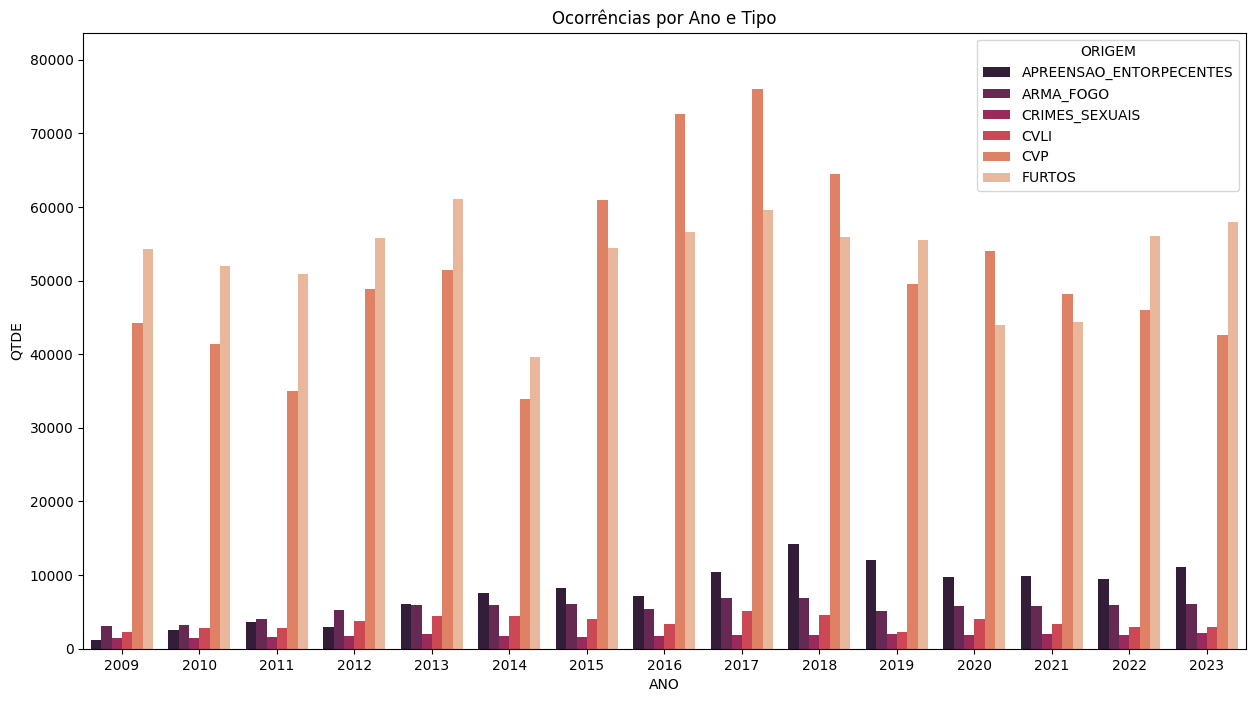

In [7]:
df_ocor_ano_origem = df_ocor[['ANO', 'ORIGEM', 'QTDE']].groupby(by = ['ANO', 'ORIGEM'], as_index = False).sum()

df_ocor_ano_origem.sort_values(by = 'ANO')

plot_bar(df_ocor_ano_origem, 'ANO', 'QTDE', 'Ocorrências por Ano e Tipo', legenda = 'ORIGEM')

No gráfico exibido, podemos observar a distribuição das ocorrências por tipo. É evidente que os crimes violentos contra o patrimônio (CVP) e os furtos possuem uma representatividade significativa em comparação com as demais categorias. Também é muito perceptivel o auemnto de apreensão de entorpecentes e armas de fogo. 

### 2.2 Ocorrências por AIS

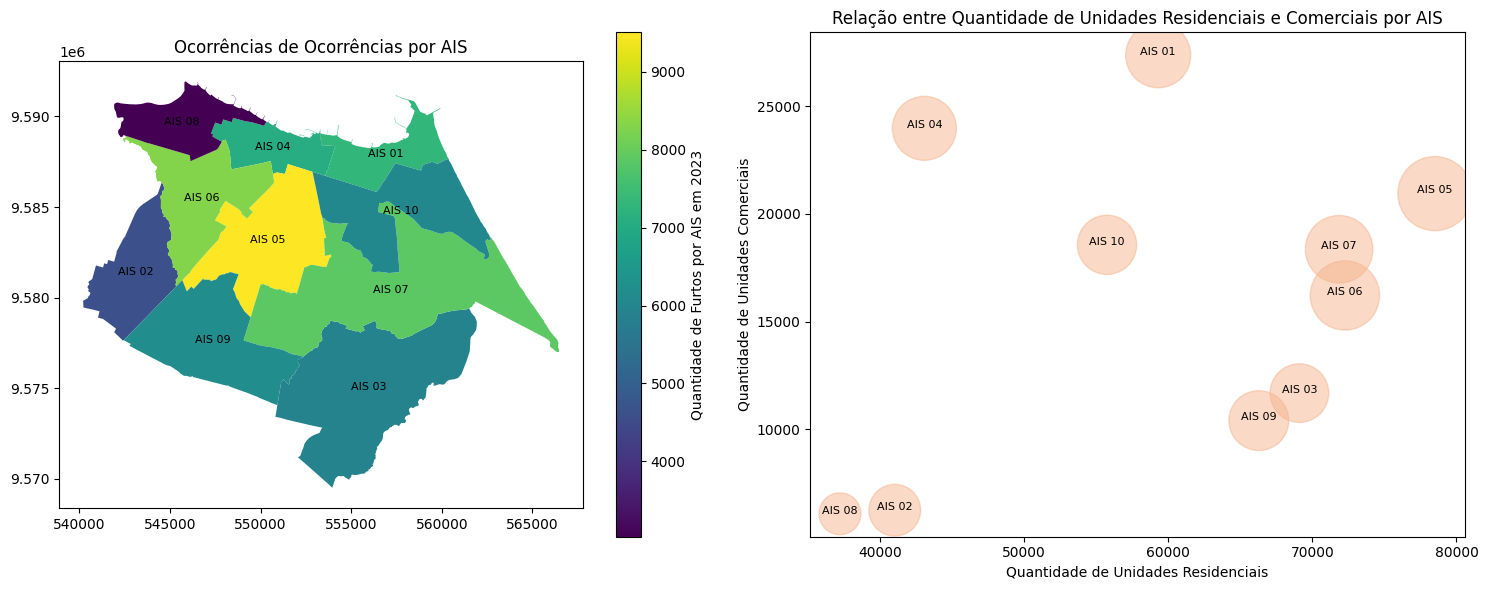

In [20]:
# dados ocorrencia do ano de 2023
df_ocor_ano = df_ocor[['ANO', 'AIS', 'QTDE']].groupby(by = ['ANO', 'AIS'], as_index = False).sum()

df_ocor_ano = df_ocor_ano[df_ocor_ano['ANO'] == 2023]

# dados geoespaciais
df_bairros_1 = df_bairros[['nome_bairro', 'the_geom', 'qtd_unidades_residencial', 'qtd_unidades_comercial']]

df_bairros_1['AIS'] = df_bairros_1['nome_bairro'].apply(lambda x: ais_bairro(x)) 

geometrias_bairros = [loads(coords) for coords in df_bairros_1['the_geom']]

gdf_bairros = gpd.GeoDataFrame(df_bairros_1, geometry = geometrias_bairros, crs='EPSG:32724')

bairros_por_ais = gdf_bairros.groupby('AIS')

geometrias_ais = []

for ais, grupo in bairros_por_ais:
    geometria_ais = grupo.geometry.unary_union
    
    geometrias_ais.append({'AIS': ais, 'geometry': geometria_ais})

df_ais = gpd.GeoDataFrame(geometrias_ais)

# merge com as infos de segurança
df_ais = df_ais.merge(right = df_ocor_ano, on = 'AIS', how = 'left')

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Primeiro plot - Mapa de cores
df_ais.plot(column = df_ais['QTDE'], legend = True, legend_kwds  ={"label": "Quantidade de Furtos por AIS em 2023", "orientation": "vertical"}, ax = axs[0])
axs[0].set_title('Ocorrências de Ocorrências por AIS')

# Adicionando rótulos de dados ao primeiro plot
for index, row in df_ais.iterrows():
    centroid = row['geometry'].centroid
    axs[0].text(centroid.x, centroid.y, row['AIS'], fontsize=8, ha='center', va='center', color='black')

# Segundo plot - Gráfico de dispersão
df_bairros_2 = df_bairros[['nome_bairro', 'the_geom', 'qtd_unidades_residencial', 'qtd_unidades_comercial']]

df_bairros_2['AIS'] = df_bairros_2['nome_bairro'].apply(lambda x: ais_bairro(x)) 

df_bairros_2 = df_bairros_2[['AIS', 'qtd_unidades_residencial', 'qtd_unidades_comercial']].groupby(by = 'AIS', as_index = False).sum()

df_bairros_2 = df_bairros_2.merge(right = df_ocor_ano, on = 'AIS', how = 'left')

axs[1].scatter(df_bairros_2['qtd_unidades_residencial'], df_bairros_2['qtd_unidades_comercial'], s = df_bairros_2['QTDE'] * 0.3, color = '#f6b48e', alpha = 0.5, label = 'Unidades Residenciais-Comerciais')
axs[1].set_title('Relação entre Quantidade de Unidades Residenciais e Comerciais por AIS')
axs[1].set_xlabel('Quantidade de Unidades Residenciais')
axs[1].set_ylabel('Quantidade de Unidades Comerciais')

# Adicionando rótulos de dados ao segundo plot
for i, txt in enumerate(df_bairros_2['AIS']):
    axs[1].text(df_bairros_2['qtd_unidades_residencial'][i], df_bairros_2['qtd_unidades_comercial'][i] + 10, txt, fontsize = 8, ha = 'center')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

plt.show()

As AIS compostas por bairros localizados mais afastados do centro da capital tendem a registrar menor incidência de ocorrências. Esta observação é consistente com a menor concentração de unidades comerciais nesses bairros em comparação com as unidades residenciais. É notável que as áreas caracterizadas por uma maior presença de bairros comerciais apresentam uma quantidade significativamente maior de ocorrências. Este padrão é esperado, uma vez que as regiões comerciais geralmente atraem um maior fluxo de pessoas, que frequentemente circulam com bens de valor e dinheiro. 

A AIS 05 registra o maior número de ocorrências, seguida pela AIS 06 e AIS 07. Por outro lado, as AIS 02 e 08 apresentam a menor quantidade de ocorrências.

Embora nosso objetivo não fosse realizar uma análise exaustiva, ficou evidente como as visualizações de dados podem fornecer insights valiosos sobre questões complexas, como a segurança urbana. A capacidade de representar dados em mapas e gráficos facilita a compreensão dos padrões espaciais e a identificação de áreas de maior preocupação.